# Ratio Approach

In [2]:
import os
os.chdir("../../")

import numpy as np
import pandas as pd

from src.tourism.mtsmodel import *
from src.tourism.ts_eval import *

import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt

import sys
import arviz as az
try:
    import bambi as bmb
except ImportError:
    !{sys.executable} -m pip install --upgrade bambi
    import bambi as bmb
    
import warnings
warnings.filterwarnings("ignore")

[2024-02-15 17:32:40 - pytensor.tensor.blas:1016 - WARNING] Using NumPy C-API based implementation for BLAS functions.


In [3]:
def run_ratio_model(country: str):
    model = RatioPipe(country=country,
                    y_var="total",
                    exog_var=["covid", "stringency_index", "samoa_travel"])
    model.read_and_merge()
    model.transform()
    model.fit(formula="ratio~covid * stringency_index+C(quarter)+" +
            str(country) + "_travel")
    pred_df = model.get_prediction()
    model.get_benchmark_evaluation()
    return model

def plot_observed(data, ax):
    data.plot(x="date", y="total", color="blue", ax=ax)
    data.plot(x="date", y="pred_mean", color="darkgreen", linestyle="dashed", ax=ax)
    return ax

[2024-02-15 17:33:30 - pymc.stats.convergence:177 - ERROR] There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


[2024-02-15 17:33:46 - pymc.stats.convergence:177 - ERROR] There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


[2024-02-15 17:34:02 - pymc.stats.convergence:177 - ERROR] There were 42 divergences after tuning. Increase `target_accept` or reparameterize.


[2024-02-15 17:34:18 - pymc.stats.convergence:177 - ERROR] There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


(0.0, 1.0, 0.0, 1.0)

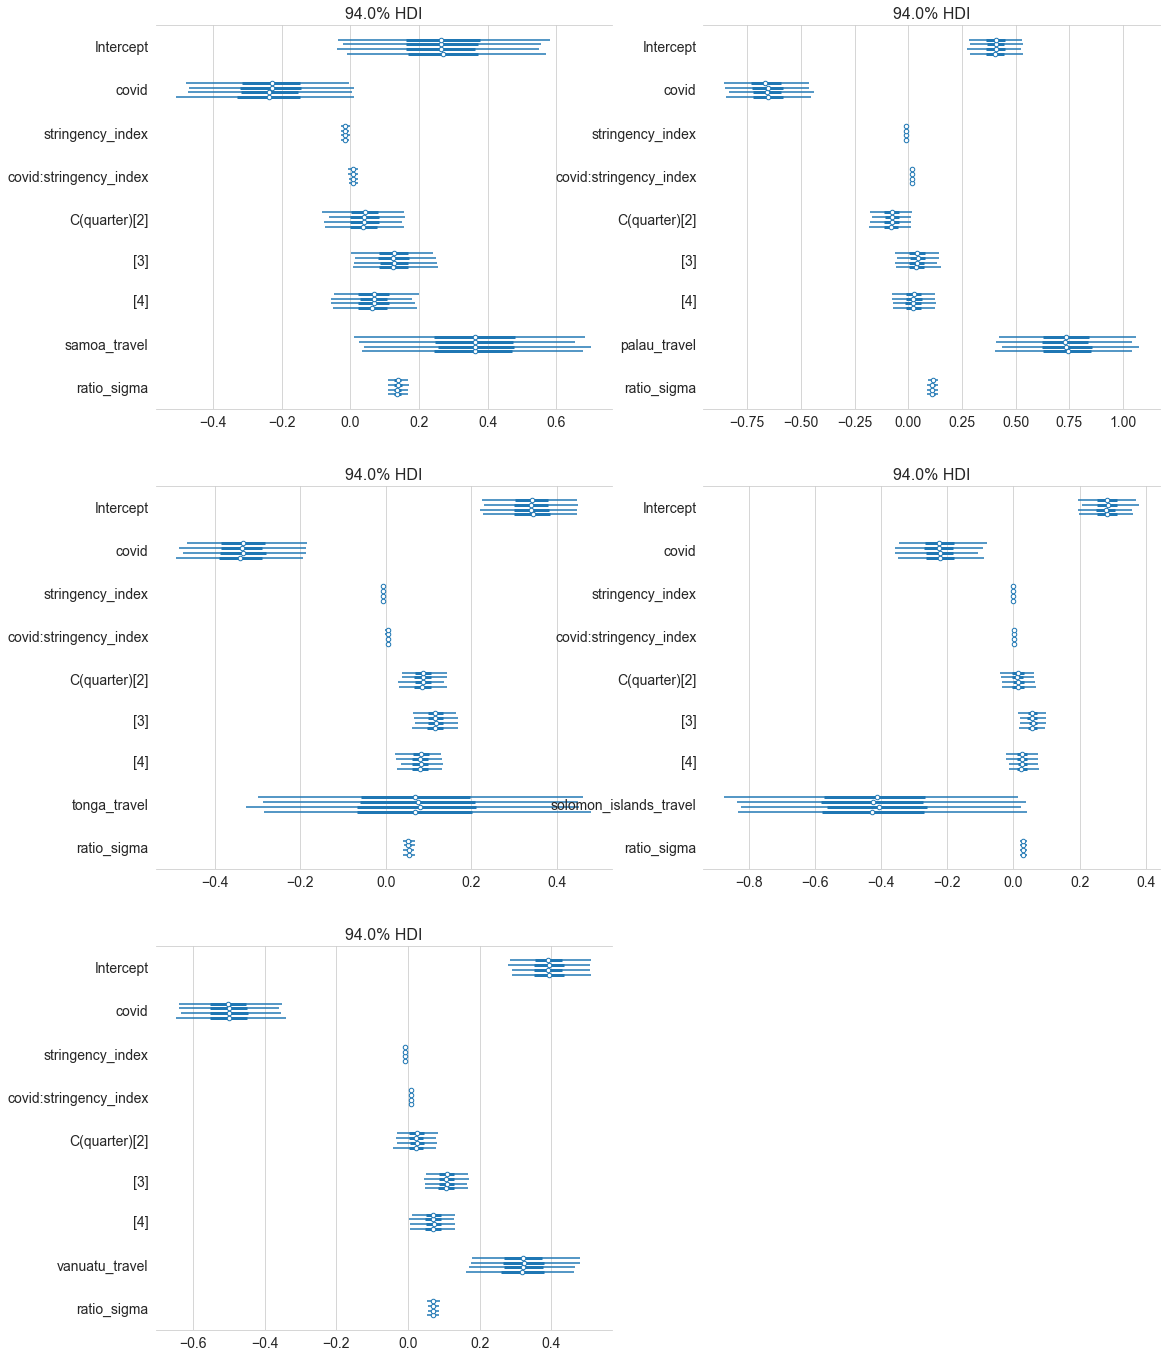

In [4]:
country_list = ["samoa", "palau", "tonga", "solomon_islands", "vanuatu"]
models = [run_ratio_model(country) for country in country_list]

fig, axes = plt.subplots(3, 2, figsize=(18, 24))
for idx, (country, model) in enumerate(zip(country_list, models)):
    data = model.model_data.dropna()
    blr = bmb.Model(
        "ratio ~ covid*stringency_index + C(quarter) +" + str(country) +
        "_travel", data)
    trace = blr.fit(tune=2000, draws=2000, return_inferencedata=True)
    row = idx // 2
    column = idx % 2
    az.plot_forest(trace, ax=axes[row, column])
axes[-1, -1].axis('off')

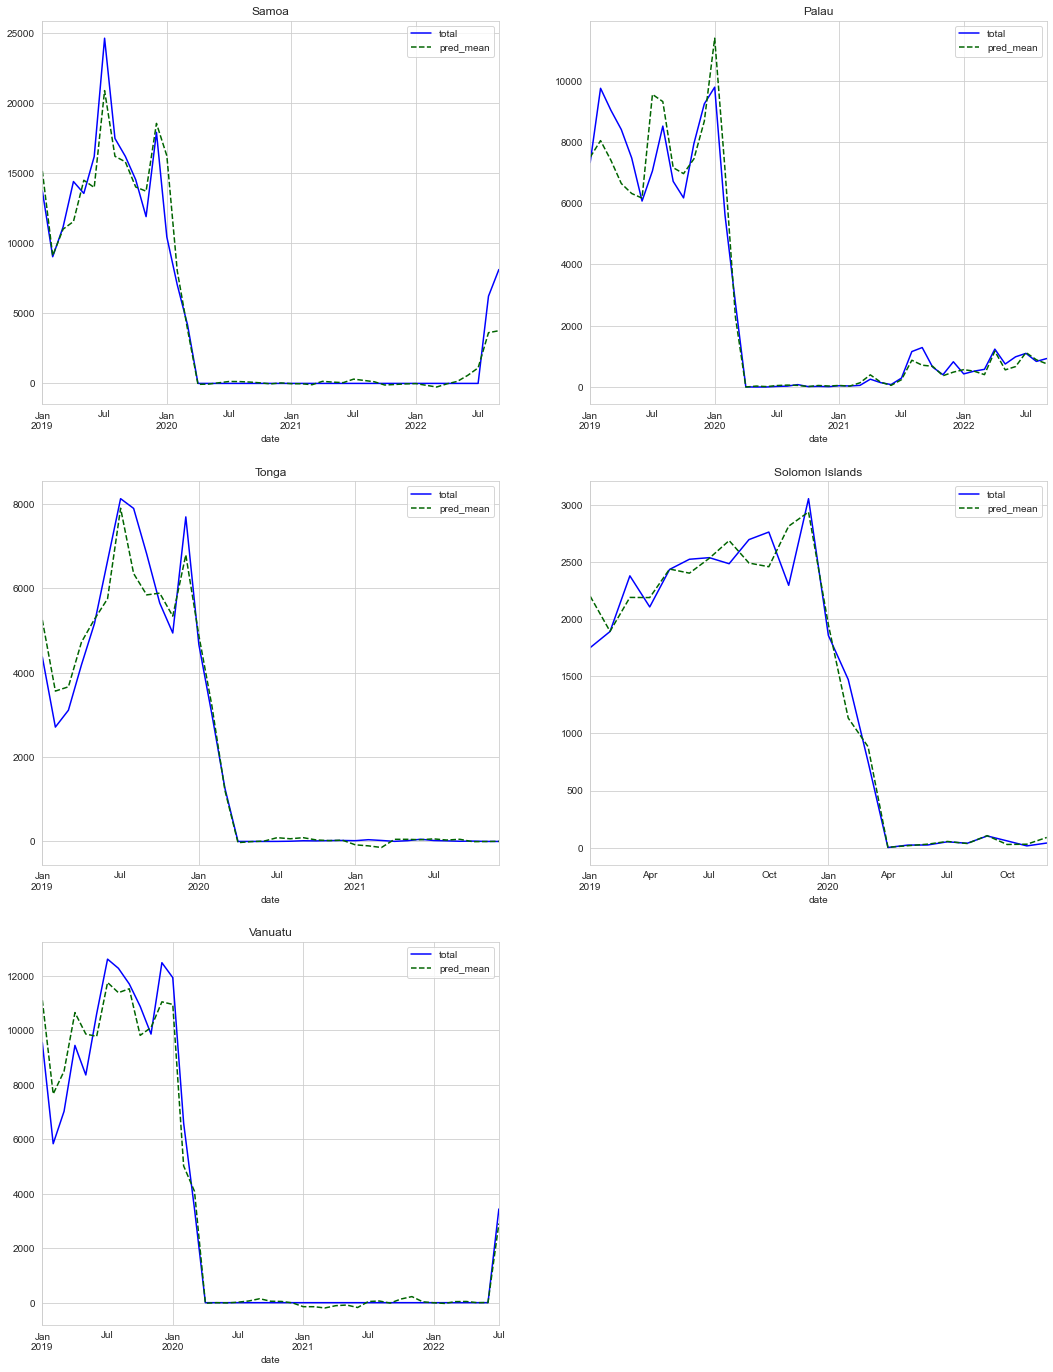

In [13]:
fig, axes = plt.subplots(3, 2, figsize=(18, 24))
for idx, model in enumerate(models):
    row = idx // 2
    column = idx % 2
    ax = plot_observed(model.prediction, ax=axes[row, column])
    country_name = " ".join(i[0].upper() + i[1:] for i in country_list[idx].split("_"))
    ax.set_title(country_name)
    
axes[-1, -1].axis('off')
plt.show()